In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp 
import os, sys
import matplotlib as mpl
from matplotlib import pylab as plt

# Reading Accel data

In [48]:
sub = '92'
df = pd.read_csv('data/%s.csv' % str(sub), delimiter=';')
print df

               time      x      y      z  gforce
0      14:08:54:919  0.070  0.215  1.016   1.041
1      14:08:54:934  0.094  0.227  1.032   1.061
2      14:08:54:936  0.086  0.199  1.020   1.043
3      14:08:54:953  0.059  0.168  0.997   1.013
4      14:08:54:965  0.047  0.168  0.973   0.989
5       14:08:55:41  0.031  0.176  0.965   0.982
6       14:08:55:46  0.023  0.176  0.962   0.978
7       14:08:55:76  0.023  0.176  0.973   0.989
8       14:08:55:78  0.020  0.176  0.985   1.001
9       14:08:55:79  0.012  0.168  0.993   1.007
10      14:08:55:82  0.000  0.156  1.005   1.017
11      14:08:55:99 -0.004  0.149  1.008   1.019
12     14:08:55:101  0.000  0.152  1.016   1.028
13     14:08:55:103  0.004  0.152  1.012   1.024
14     14:08:55:143  0.008  0.152  1.005   1.016
15     14:08:55:145  0.008  0.160  1.001   1.013
16     14:08:55:146  0.012  0.160  1.008   1.021
17     14:08:55:171  0.012  0.156  1.005   1.017
18     14:08:55:176  0.008  0.152  1.001   1.012
19     14:08:55:201 

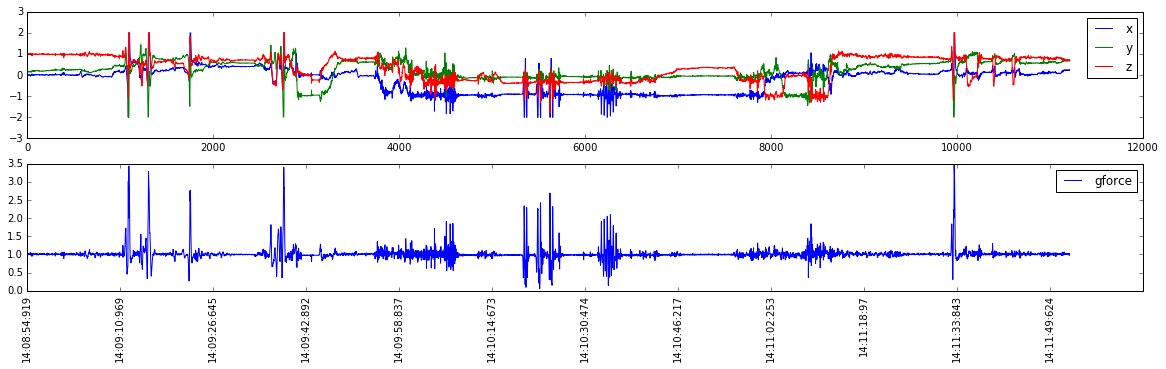

In [55]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(20,5))
ax1.plot(df['x'])
ax1.plot(df['y'])
ax1.plot(df['z'])
ax1.legend()

ax2.plot(df['gforce'])
ax2.legend()

tp_interval=1000
plt.xticks(range(0,len(df['time']),tp_interval), df['time'][range(0,len(df['time']),tp_interval)], rotation='90')

plt.show()

# Reading sound .amr file

In [113]:
# Convert between network and filesystem views of AMR files
# E. Woudenberg, Lobby7 Feb 2003
# Tested under WinXP/Cygwin

import os, sys, struct, array

class nibble_reader:
    def __init__(self, data):
        self.data = array.array('B', data)
        self.i = 0
    def read(self):
        if self.i/2 >= len(self.data):
            return None
        c = self.data[self.i/2]
        if self.i % 2:
            c >>= 4
        c &= 0xF
        self.i += 1
        return c

class nibble_writer:
    def __init__(self):
        self.out = array.array('B')
        self.i = 0
    def write(self, n):
        if self.i % 2:
            self.out[self.i/2] |= n<<4;
        else:
            self.out.append(n)
        self.i += 1
    def tostring(self):
        return self.out.tostring()

def makefliptab():
    global fliptab
    fliptab = []
    for i in range(256):
        fliptab.append(bytflip(i))

def bytflip(n):
    return nybflip(n>>4) + (nybflip(n&0xf)<<4)

def nybflip(n):
    f = ((n&1)<<3) + ((n&2)<<1) + ((n&4)>>1) + ((n&8)>>3)
# print '%d%d%d%d' % ((f&8!=0),(f&4!=0),(f&2!=0),(f&1!=0))
    return f

# AMR file has bits in Network Bit Order, which is most significant bit
# first. Here we mirror them to restore their order.

def flip_bitorder(b):
    a = array.array('B',b)
    for i in range(len(a)):
        a[i] = fliptab[a[i]]
    return a.tostring()

Framebits = [95,103,118,134,148,159,204,244]

def amr2if2(inf, outf):
    
    outD = []
    
    f = open(inf,'rb')
    fw = open(outf, 'wb')

    head = f.read(6)
    if head != '#!AMR\n':
        print 'not an #!AMR file'
        sys.exit(1)

    frameno = 0
    while 1:
        ft = f.read(1)
        if len(ft) == 0: break
        fb = struct.unpack('B', ft)[0]
        if not (fb & 4):
            print 'invalid frame at frameno %d, exiting' % frameno
            sys.exit(1)
        ftype = (fb >> 3) & 0xF
        fsize = (Framebits[ftype]+7)/8
        # print 'frametype', ftype, 'framesize', fsize
        frame = f.read(fsize)
        nr = nibble_reader(flip_bitorder(frame))
        nw = nibble_writer()
        nw.write(ftype)
        while 1:
            n = nr.read()
            if n == None: break
            nw.write(n)
        outfsize = (Framebits[ftype]+4+7)/8 # round to byte count, include ftype nibble        
        fw.write(nw.tostring()[:outfsize])

        outD.append(nw.out)
        
        frameno += 1
    print 'Processed %d frames, created %s' % (frameno, outf)
    return outD


In [114]:
makefliptab()
nr = amr2if2('data/%s.amr' % str(sub), 'data/%s.cod' % str(sub))

Processed 5683 frames, created data/92.cod


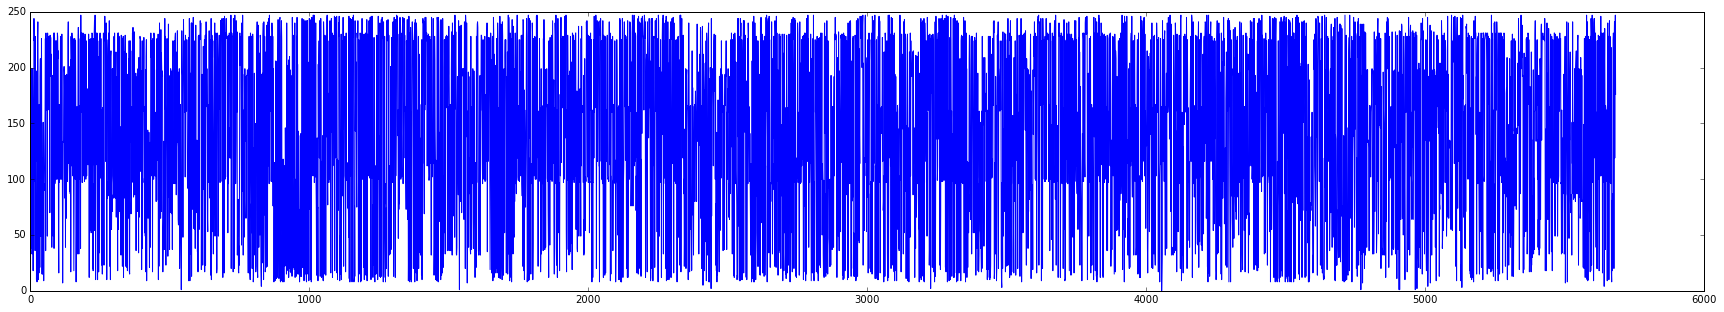

In [148]:
plt.subplots(figsize=(30,5))
plt.plot(np.array(nr).T[10])

In [142]:
np.shape(nr[0])

AttributeError: 'list' object has no attribute 'T'